In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [117]:
# Neural Network for Images (67103) - Exercise 1
# Submission by: Amit Halbreich

# Neural Network for Images (67103) - Exercise 1
# Submission by: Amit Halbreich

In [3]:
# Weights & Biases

!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 21.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 KB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.3 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=362dce3649fd89035910910e2b8f09b3506e3eb57b8a36dfbbdb55eff3724cd6
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools


In [4]:
import wandb

wandb.init(project="ex1-amith",
  config={
  "learning_rate": 0.001,
  "architecture": "CNN",
  "dataset": "CIFAR-100",
  "epochs": 10,
  }
)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc



# Training a Classifier

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

## What about data?

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
ImageNet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


## Training an image classifier

We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

### 1. Load and normalize CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.


In [5]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



<div class="alert alert-info"><h4>Note</h4><p>If running on Windows and you get a BrokenPipeError, try setting
    the num_worker of torch.utils.data.DataLoader() to 0.</p></div>



In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us show some of the training images, for fun.



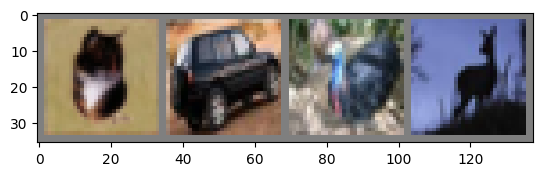

cat   car   bird  deer 


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


### 2. Define a Convolutional Neural Network
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [9]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 5)
        self.maxPool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.maxPool(F.relu(self.conv1(x)))
        x = self.maxPool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        return x


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (maxPool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [14]:
# Question 1 - Overfitting
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 200)
        self.fc2 = nn.Linear(200, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)

In [23]:
# Question 1 - Underfitting
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [59]:
# Question 1 - Overfitting
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [76]:
# Question 1 - Underfitting New
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 32, 5)
        self.conv3 = nn.Conv2d(32, 16, 5)
        self.fc1 = nn.Linear(16, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        return x


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=16, out_features=10, bias=True)
)

In [35]:
# Question 2 - No Linear Components Network
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.avgPool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 8, 5)
        self.fc1 = nn.Linear(8 * 5 * 5, 10)

    def forward(self, x):
        x = self.avgPool(self.conv1(x))
        x = self.avgPool(self.conv2(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        return x


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (avgPool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(16, 8, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=200, out_features=10, bias=True)
)

In [45]:
# Question 3 - Using Global Average Pooling
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.globalAvgPool = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(32, 10)


    def forward(self, x):
        x = self.globalAvgPool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        return x


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (globalAvgPool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=32, out_features=10, bias=True)
)

In [89]:
# Question 3 - Using first convonutinal Layer then apply FC Layer
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.fc1 = nn.Linear(32 * 28 * 28, 10)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        return x


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=25088, out_features=10, bias=True)
)

In [112]:
# Question 3 - Using first convonutinal Layer then apply FC Layer
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.fc1 = nn.Linear(16 * 28 * 28, 10)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        return x


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=12544, out_features=10, bias=True)
)

### 3. Define a Loss function and optimizer
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [122]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
loss_values = []
test_loss_values = []

### 4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [123]:
def train_network(net, criterion, optimizer, trainloader, testloader, device, num_epochs):

    def train(trainloader, net, criterion, optimizer, device):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

        # Compute the average loss for the entire training set
        train_total_loss = running_loss/len(trainloader)

        return train_total_loss

    def test(testloader, net, criterion, optimizer, device):
        running_loss_test = 0.0
        for i, data in enumerate(testloader, 0):
            with torch.no_grad():
              # get the inputs; data is a list of [inputs, labels]
              inputs, labels = data[0].to(device), data[1].to(device)

              # forward
              outputs = net(inputs)
              loss = criterion(outputs, labels)

              # print statistics
              running_loss_test += loss.item()

        # Compute the average loss for the entire test set
        test_total_loss = running_loss_test/len(testloader)

        return test_total_loss

    loss_values = []
    test_loss_values = []

    for epoch in range(1,num_epochs,1):  # loop over the dataset multiple times
        train_total_loss = train(trainloader, net, criterion, optimizer, device)
        test_total_loss = test(testloader, net, criterion, optimizer, device)

        # log the losses to wandb
        wandb.log({"Train Loss": train_total_loss, "Test Loss": test_total_loss, "Epoch": epoch})

        # append the losses to their respective lists
        loss_values.append(train_total_loss)
        test_loss_values.append(test_total_loss)

        print('Epoch %d: Train loss: %.3f, Test loss: %.3f' %
                (epoch, train_total_loss, test_total_loss))

    # Plot the training and validation loss
    plt.plot(loss_values, label='Training Set')
    plt.plot(test_loss_values, label='Test Set')
    plt.title('Net Model Loss (Training & Test)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training Set', 'Test Set'], loc='upper right')
    plt.show()

    # Report the total number of learnable parameters
    total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
    print('Total number of learnable parameters: {}'.format(total_params))
    wandb.log({"Total Learned Parameters": total_params})

    print('Finished Training')

Epoch 1: Train loss: 1.435, Test loss: 1.166
Epoch 2: Train loss: 1.083, Test loss: 1.023
Epoch 3: Train loss: 0.962, Test loss: 0.965
Epoch 4: Train loss: 0.897, Test loss: 0.944
Epoch 5: Train loss: 0.843, Test loss: 0.956
Epoch 6: Train loss: 0.807, Test loss: 0.920
Epoch 7: Train loss: 0.772, Test loss: 0.955
Epoch 8: Train loss: 0.748, Test loss: 0.935


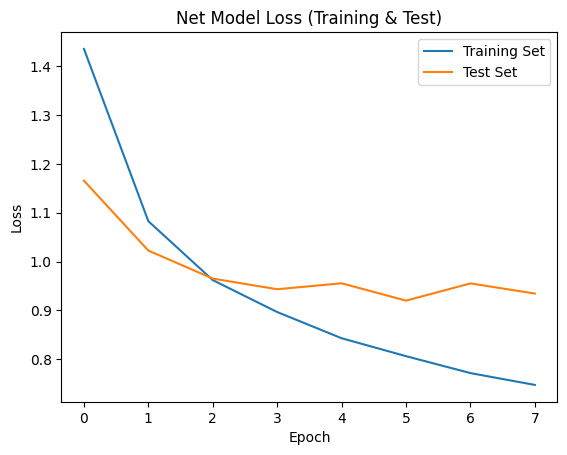

Total number of learnable parameters: 163230
Finished Training


In [124]:
train_network(net, criterion, optimizer, trainloader, testloader, device, 9)

Epoch 1: Train loss: 1.605, Test loss: 1.368
Epoch 2: Train loss: 1.225, Test loss: 1.239
Epoch 3: Train loss: 1.063, Test loss: 1.058
Epoch 4: Train loss: 0.946, Test loss: 1.091
Epoch 5: Train loss: 0.869, Test loss: 1.106
Epoch 6: Train loss: 0.803, Test loss: 0.994
Epoch 7: Train loss: 0.746, Test loss: 1.017
Epoch 8: Train loss: 0.706, Test loss: 0.958
Epoch 9: Train loss: 0.662, Test loss: 1.055
Epoch 10: Train loss: 0.622, Test loss: 0.983
Epoch 11: Train loss: 0.590, Test loss: 1.094
Epoch 12: Train loss: 0.562, Test loss: 1.072
Epoch 13: Train loss: 0.542, Test loss: 1.096
Epoch 14: Train loss: 0.512, Test loss: 1.149
Epoch 15: Train loss: 0.497, Test loss: 1.146
Epoch 16: Train loss: 0.487, Test loss: 1.152
Epoch 17: Train loss: 0.467, Test loss: 1.201
Epoch 18: Train loss: 0.451, Test loss: 1.386
Epoch 19: Train loss: 0.434, Test loss: 1.246
Epoch 20: Train loss: 0.425, Test loss: 1.361
length loss_values: 20
length test_loss_values: 20


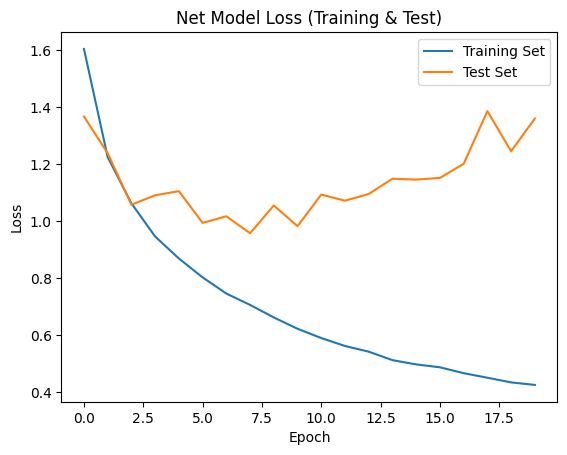

Total number of learnable parameters: 106008
Finished Training


In [16]:
train_network(net, criterion, optimizer, trainloader, testloader, device, 21)

Epoch 1: Train loss: 1.586, Test loss: 1.263
Epoch 2: Train loss: 1.172, Test loss: 1.081
Epoch 3: Train loss: 0.982, Test loss: 1.001
Epoch 4: Train loss: 0.860, Test loss: 0.909
Epoch 5: Train loss: 0.775, Test loss: 0.893
Epoch 6: Train loss: 0.704, Test loss: 0.881
Epoch 7: Train loss: 0.648, Test loss: 0.943
Epoch 8: Train loss: 0.590, Test loss: 0.921
Epoch 9: Train loss: 0.548, Test loss: 0.952
Epoch 10: Train loss: 0.505, Test loss: 0.979
Epoch 11: Train loss: 0.471, Test loss: 1.014
Epoch 12: Train loss: 0.444, Test loss: 1.047
Epoch 13: Train loss: 0.410, Test loss: 1.078
Epoch 14: Train loss: 0.389, Test loss: 1.132
Epoch 15: Train loss: 0.362, Test loss: 1.184


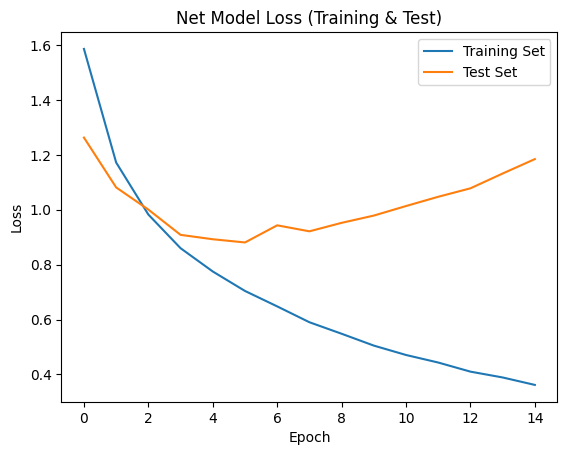

Total number of learnable parameters: 167530
Finished Training


In [61]:
train_network(net, criterion, optimizer, trainloader, testloader, device, 16)

Epoch 1: Train loss: 1.522, Test loss: 1.240
Epoch 2: Train loss: 1.140, Test loss: 1.068
Epoch 3: Train loss: 0.995, Test loss: 0.963
Epoch 4: Train loss: 0.909, Test loss: 0.974
Epoch 5: Train loss: 0.855, Test loss: 0.948
Epoch 6: Train loss: 0.809, Test loss: 0.958
Epoch 7: Train loss: 0.768, Test loss: 0.957
Epoch 8: Train loss: 0.740, Test loss: 0.938
Epoch 9: Train loss: 0.712, Test loss: 0.902
Epoch 10: Train loss: 0.683, Test loss: 0.994
Epoch 11: Train loss: 0.667, Test loss: 0.956


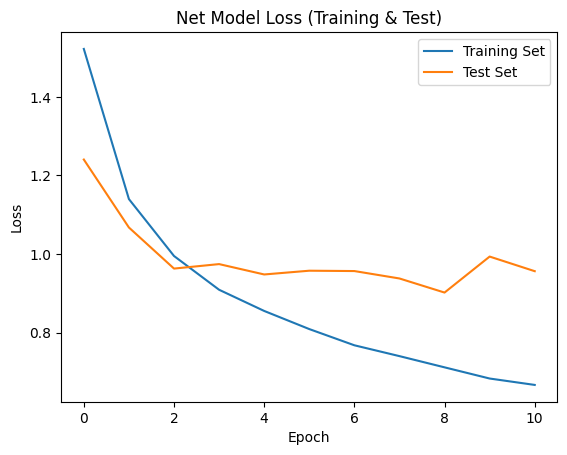

Total number of learnable parameters: 69082
Finished Training


In [78]:
train_network(net, criterion, optimizer, trainloader, testloader, device, 12)

Epoch 1: Train loss: 1.609, Test loss: 1.400
Epoch 2: Train loss: 1.225, Test loss: 1.159
Epoch 3: Train loss: 1.058, Test loss: 1.074
Epoch 4: Train loss: 0.948, Test loss: 1.198
Epoch 5: Train loss: 0.877, Test loss: 1.011
Epoch 6: Train loss: 0.820, Test loss: 1.013
Epoch 7: Train loss: 0.772, Test loss: 0.971
Epoch 8: Train loss: 0.738, Test loss: 0.972
Epoch 9: Train loss: 0.697, Test loss: 1.000
Epoch 10: Train loss: 0.669, Test loss: 0.946
length loss_values: 10
length test_loss_values: 10


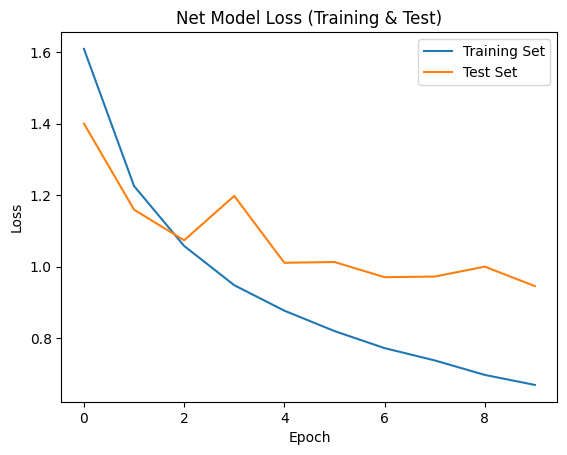

Total number of learnable parameters: 75482
Finished Training


In [25]:
train_network(net, criterion, optimizer, trainloader, testloader, device, 11)

Epoch 1: Train loss: 1.855, Test loss: 1.769
Epoch 2: Train loss: 1.803, Test loss: 1.776
Epoch 3: Train loss: 1.794, Test loss: 1.781
Epoch 4: Train loss: 1.788, Test loss: 1.782
Epoch 5: Train loss: 1.785, Test loss: 1.799
Epoch 6: Train loss: 1.781, Test loss: 1.767
Epoch 7: Train loss: 1.781, Test loss: 1.799
Epoch 8: Train loss: 1.776, Test loss: 1.798
Epoch 9: Train loss: 1.776, Test loss: 1.751
Epoch 10: Train loss: 1.774, Test loss: 1.792


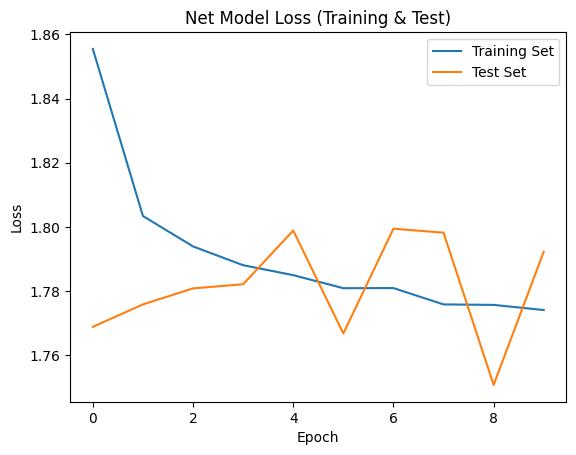

Total number of learnable parameters: 6434
Finished Training


In [38]:
train_network(net, criterion, optimizer, trainloader, testloader, device, 11)

Epoch 1: Train loss: 2.034, Test loss: 1.899
Epoch 2: Train loss: 1.843, Test loss: 1.783
Epoch 3: Train loss: 1.760, Test loss: 1.732
Epoch 4: Train loss: 1.724, Test loss: 1.708
Epoch 5: Train loss: 1.700, Test loss: 1.687
Epoch 6: Train loss: 1.678, Test loss: 1.656
Epoch 7: Train loss: 1.656, Test loss: 1.639
Epoch 8: Train loss: 1.633, Test loss: 1.619
Epoch 9: Train loss: 1.614, Test loss: 1.595
Epoch 10: Train loss: 1.597, Test loss: 1.573


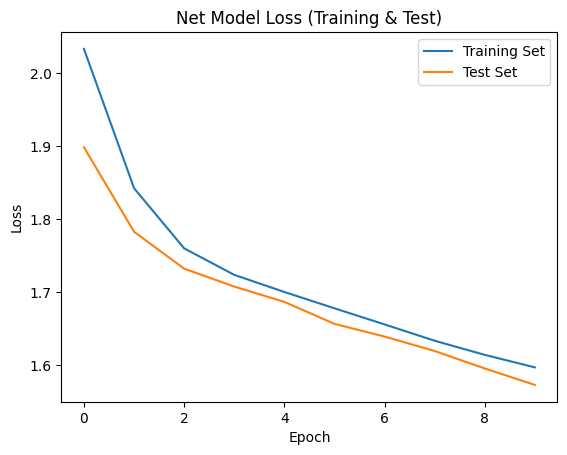

Total number of learnable parameters: 2762
Finished Training


In [47]:
train_network(net, criterion, optimizer, trainloader, testloader, device, 11)

Epoch 1: Train loss: 1.531, Test loss: 1.325
Epoch 2: Train loss: 1.253, Test loss: 1.397
Epoch 3: Train loss: 1.119, Test loss: 1.367
Epoch 4: Train loss: 1.012, Test loss: 1.329
Epoch 5: Train loss: 0.908, Test loss: 1.395
Epoch 6: Train loss: 0.814, Test loss: 1.479
Epoch 7: Train loss: 0.727, Test loss: 1.592
Epoch 8: Train loss: 0.652, Test loss: 1.644
Epoch 9: Train loss: 0.583, Test loss: 2.018
Epoch 10: Train loss: 0.532, Test loss: 1.879


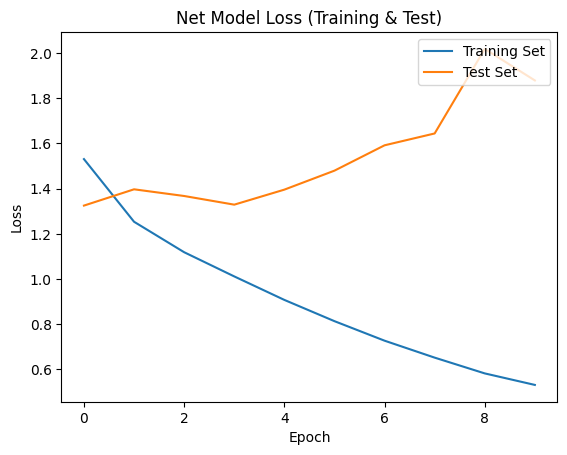

Total number of learnable parameters: 253322
Finished Training


In [91]:
train_network(net, criterion, optimizer, trainloader, testloader, device, 11)

Let's quickly save our trained model:



In [10]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html)
for more details on saving PyTorch models.

### 5. Test the network on the test data

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



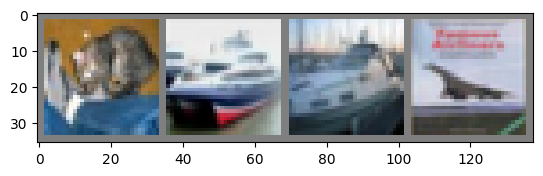

GroundTruth:  cat   ship  ship  plane


In [16]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [21]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:



In [19]:
outputs = net(images)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [111]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 53 %


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [86]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 1.6 %
Accuracy for class: car   is 82.8 %
Accuracy for class: bird  is 0.1 %
Accuracy for class: cat   is 7.6 %
Accuracy for class: deer  is 0.3 %
Accuracy for class: dog   is 2.1 %
Accuracy for class: frog  is 2.9 %
Accuracy for class: horse is 0.1 %
Accuracy for class: ship  is 0.5 %
Accuracy for class: truck is 0.1 %


Okay, so what next?

How do we run these neural networks on the GPU?

## Training on GPU
Just like how you transfer a Tensor onto the GPU, you transfer the neural
net onto the GPU.

Let's first define our device as the first visible cuda device if we have
CUDA available:



In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


The rest of this section assumes that ``device`` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:

.. code:: python

    net.to(device)


Remember that you will have to send the inputs and targets at every step
to the GPU too:

.. code:: python

        inputs, labels = data[0].to(device), data[1].to(device)

Why don't I notice MASSIVE speedup compared to CPU? Because your network
is really small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

## Training on multiple GPUs
If you want to see even more MASSIVE speedup using all of your GPUs,
please check out :doc:`data_parallel_tutorial`.

## Where do I go next?

-  :doc:`Train neural nets to play video games </intermediate/reinforcement_q_learning>`
-  `Train a state-of-the-art ResNet network on imagenet`_
-  `Train a face generator using Generative Adversarial Networks`_
-  `Train a word-level language model using Recurrent LSTM networks`_
-  `More examples`_
-  `More tutorials`_
-  `Discuss PyTorch on the Forums`_
-  `Chat with other users on Slack`_




In [ ]:
del dataiter